<a href="https://colab.research.google.com/github/Alejandro-Casanova/pytorch-deep-learning/blob/main/extras/exercises/07_pytorch_experiment_tracking_exercise_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07. PyTorch Experiment Tracking Exercise Template

Welcome to the 07. PyTorch Experiment Tracking exercise template notebook.

> **Note:** There may be more than one solution to each of the exercises. This notebook only shows one possible example.

## Resources

1. These exercises/solutions are based on [section 07. PyTorch Transfer Learning](https://www.learnpytorch.io/07_pytorch_experiment_tracking/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/cO_r2FYcAjU).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

We'll need to make sure we have `torch` v.1.12+ and `torchvision` v0.13+.

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) > 1, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [2]:
# Make sure we have a GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Get regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [4]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [5]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.

    Returns:
        pathlib.Path to downloaded data.

    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [6]:
from torch.utils.tensorboard import SummaryWriter
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str=None):
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [7]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.going_modular.engine import train_step, test_step

# Add writer parameter to train()
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]}
      For example if training for epochs=2:
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss",
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy",
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc},
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

### Download data

Using the same data from https://www.learnpytorch.io/07_pytorch_experiment_tracking/

In [8]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory exists, skipping download.
[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [9]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data/pizza_steak_sushi/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


In [10]:
print(torchvision.models.EfficientNet_B5_Weights.DEFAULT.transforms())
print(torchvision.models.EfficientNet_B0_Weights.DEFAULT.transforms())

ImageClassification(
    crop_size=[456]
    resize_size=[456]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [11]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225])

# Create a transform pipeline
simple_transform = transforms.Compose([
                                       transforms.Resize((456, 456)),
                                       transforms.ToTensor(), # get image values between 0 & 1
                                       normalize
])

### Turn data into DataLoaders

In [12]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE)

# Create 20% training and test DataLoaders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


## Exercise 1: Pick a larger model from [`torchvision.models`](https://pytorch.org/vision/main/models.html) to add to the list of experiments (for example, EffNetB3 or higher)

* How does it perform compared to our existing models?
* **Hint:** You'll need to set up an exerpiment similar to [07. PyTorch Experiment Tracking section 7.6](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#76-create-experiments-and-set-up-training-code).

In [13]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb5"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [14]:
weights = torchvision.models.EfficientNet_B5_Weights.DEFAULT # NEW in torchvision 0.13, "DEFAULT" means "best weights available"
model = torchvision.models.efficientnet_b5(weights=weights).to(device)

print(model.classifier.parameters)

summary(model,
        input_size=(32, 3, 456, 456), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

<bound method Module.parameters of Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=2048, out_features=1000, bias=True)
)>


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 456, 456]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 456, 456]    [32, 2048, 15, 15]   --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 456, 456]    [32, 48, 228, 228]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 456, 456]    [32, 48, 228, 228]   1,296                True
│    │    └─BatchNorm2d (1)                                  [32, 48, 228, 228]   [32, 48, 228, 228]   96                   True
│    │    └─SiLU (2)                                         [32, 48, 228, 228]   [32, 48, 228, 228]   --                   --
│    └─Sequential (1)                                        [32, 48, 228, 228]   [32, 24, 228

In [15]:
# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0(out_features: int = OUT_FEATURES):
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=out_features)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB5 feature extractor
def create_effnetb5(out_features: int = OUT_FEATURES):
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B5_Weights.DEFAULT
    model = torchvision.models.efficientnet_b5(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = torch.nn.Sequential(
        nn.Dropout(p=0.4, inplace=True),
        nn.Linear(in_features=2048,
        out_features=out_features,
        bias=True).to(device))

    # 5. Give the model a name
    model.name = "effnetb5"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [16]:
%%time
from going_modular.going_modular.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs:

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")

            # 7. Select the model
            if model_name == "effnetb0":
                model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb5() # creates a new model each time (important because we want each experiment to start from scratch)

            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))

            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2023-10-05/data_10_percent/effnetb0/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0561 | train_acc: 0.5156 | test_loss: 0.9372 | test_acc: 0.6714
Epoch: 2 | train_loss: 0.8869 | train_acc: 0.7305 | test_loss: 0.8734 | test_acc: 0.6506
Epoch: 3 | train_loss: 0.8458 | train_acc: 0.6445 | test_loss: 0.7627 | test_acc: 0.8239
Epoch: 4 | train_loss: 0.7678 | train_acc: 0.7539 | test_loss: 0.6019 | test_acc: 0.8854
Epoch: 5 | train_loss: 0.6395 | train_acc: 0.8672 | test_loss: 0.6011 | test_acc: 0.8958
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb5
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb5 model.
[INFO] Created SummaryWriter, saving to: runs/2023-10-05/data_10_percent/effnetb5/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0538 | train_acc: 0.4609 | test_loss: 0.7933 | test_acc: 0.9479
Epoch: 2 | train_loss: 0.8470 | train_acc: 0.7500 | test_loss: 0.6884 | test_acc: 0.9384
Epoch: 3 | train_loss: 0.7292 | train_acc: 0.9102 | test_loss: 0.5502 | test_acc: 0.9792
Epoch: 4 | train_loss: 0.6772 | train_acc: 0.7617 | test_loss: 0.4620 | test_acc: 0.9688
Epoch: 5 | train_loss: 0.5853 | train_acc: 0.7852 | test_loss: 0.4514 | test_acc: 0.9593
[INFO] Saving model to: models/07_effnetb5_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2023-10-05/data_10_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0561 | train_acc: 0.5156 | test_loss: 0.9372 | test_acc: 0.6714
Epoch: 2 | train_loss: 0.8869 | train_acc: 0.7305 | test_loss: 0.8734 | test_acc: 0.6506
Epoch: 3 | train_loss: 0.8458 | train_acc: 0.6445 | test_loss: 0.7627 | test_acc: 0.8239
Epoch: 4 | train_loss: 0.7678 | train_acc: 0.7539 | test_loss: 0.6019 | test_acc: 0.8854
Epoch: 5 | train_loss: 0.6395 | train_acc: 0.8672 | test_loss: 0.6011 | test_acc: 0.8958
Epoch: 6 | train_loss: 0.6105 | train_acc: 0.8867 | test_loss: 0.6142 | test_acc: 0.8750
Epoch: 7 | train_loss: 0.6173 | train_acc: 0.7734 | test_loss: 0.5659 | test_acc: 0.9062
Epoch: 8 | train_loss: 0.4911 | train_acc: 0.9453 | test_loss: 0.5174 | test_acc: 0.9271
Epoch: 9 | train_loss: 0.6155 | train_acc: 0.7695 | test_loss: 0.5364 | test_acc: 0.8447
Epoch: 10 | train_loss: 0.5128 | train_acc: 0.8164 | test_loss: 0.4572 | test_acc: 0.9167
[INFO] Saving model to: models/07_effnetb0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0538 | train_acc: 0.4609 | test_loss: 0.7933 | test_acc: 0.9479
Epoch: 2 | train_loss: 0.8470 | train_acc: 0.7500 | test_loss: 0.6884 | test_acc: 0.9384
Epoch: 3 | train_loss: 0.7292 | train_acc: 0.9102 | test_loss: 0.5502 | test_acc: 0.9792
Epoch: 4 | train_loss: 0.6772 | train_acc: 0.7617 | test_loss: 0.4620 | test_acc: 0.9688
Epoch: 5 | train_loss: 0.5853 | train_acc: 0.7852 | test_loss: 0.4514 | test_acc: 0.9593
Epoch: 6 | train_loss: 0.6021 | train_acc: 0.8242 | test_loss: 0.3968 | test_acc: 0.9896
Epoch: 7 | train_loss: 0.5885 | train_acc: 0.8125 | test_loss: 0.3733 | test_acc: 0.9792
Epoch: 8 | train_loss: 0.4924 | train_acc: 0.8398 | test_loss: 0.3646 | test_acc: 0.9792
Epoch: 9 | train_loss: 0.4738 | train_acc: 0.8320 | test_loss: 0.3509 | test_acc: 0.9792
Epoch: 10 | train_loss: 0.4603 | train_acc: 0.8438 | test_loss: 0.3121 | test_acc: 0.9792
[INFO] Saving model to: models/07_effnetb5_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9807 | train_acc: 0.5646 | test_loss: 0.7025 | test_acc: 0.8854
Epoch: 2 | train_loss: 0.7229 | train_acc: 0.8708 | test_loss: 0.6240 | test_acc: 0.8958
Epoch: 3 | train_loss: 0.6287 | train_acc: 0.8146 | test_loss: 0.4582 | test_acc: 0.9271
Epoch: 4 | train_loss: 0.5274 | train_acc: 0.8604 | test_loss: 0.4429 | test_acc: 0.9479
Epoch: 5 | train_loss: 0.5061 | train_acc: 0.8146 | test_loss: 0.3941 | test_acc: 0.9375
[INFO] Saving model to: models/07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb5
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb5 model.
[INFO] Created SummaryWriter, saving to: runs/2023-10-05/data_20_percent/effnetb5/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9328 | train_acc: 0.6729 | test_loss: 0.6360 | test_acc: 0.9176
Epoch: 2 | train_loss: 0.6591 | train_acc: 0.8562 | test_loss: 0.5118 | test_acc: 0.9280
Epoch: 3 | train_loss: 0.5746 | train_acc: 0.8438 | test_loss: 0.4020 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.4422 | train_acc: 0.9271 | test_loss: 0.3698 | test_acc: 0.8475
Epoch: 5 | train_loss: 0.4388 | train_acc: 0.8833 | test_loss: 0.3062 | test_acc: 0.9384
[INFO] Saving model to: models/07_effnetb5_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2023-10-05/data_20_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9807 | train_acc: 0.5646 | test_loss: 0.7025 | test_acc: 0.8854
Epoch: 2 | train_loss: 0.7229 | train_acc: 0.8708 | test_loss: 0.6240 | test_acc: 0.8958
Epoch: 3 | train_loss: 0.6287 | train_acc: 0.8146 | test_loss: 0.4582 | test_acc: 0.9271
Epoch: 4 | train_loss: 0.5274 | train_acc: 0.8604 | test_loss: 0.4429 | test_acc: 0.9479
Epoch: 5 | train_loss: 0.5061 | train_acc: 0.8146 | test_loss: 0.3941 | test_acc: 0.9375
Epoch: 6 | train_loss: 0.4075 | train_acc: 0.9250 | test_loss: 0.3464 | test_acc: 0.9479
Epoch: 7 | train_loss: 0.3856 | train_acc: 0.9104 | test_loss: 0.3142 | test_acc: 0.9167
Epoch: 8 | train_loss: 0.3851 | train_acc: 0.8917 | test_loss: 0.3274 | test_acc: 0.9479
Epoch: 9 | train_loss: 0.3220 | train_acc: 0.9187 | test_loss: 0.2858 | test_acc: 0.9375
Epoch: 10 | train_loss: 0.3852 | train_acc: 0.9000 | test_loss: 0.2780 | test_acc: 0.9479
[INFO] Saving model to: models/07_effnetb0_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9328 | train_acc: 0.6729 | test_loss: 0.6360 | test_acc: 0.9176
Epoch: 2 | train_loss: 0.6591 | train_acc: 0.8562 | test_loss: 0.5118 | test_acc: 0.9280
Epoch: 3 | train_loss: 0.5746 | train_acc: 0.8438 | test_loss: 0.4020 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.4422 | train_acc: 0.9271 | test_loss: 0.3698 | test_acc: 0.8475
Epoch: 5 | train_loss: 0.4388 | train_acc: 0.8833 | test_loss: 0.3062 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.3662 | train_acc: 0.9271 | test_loss: 0.2618 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.3817 | train_acc: 0.8979 | test_loss: 0.2448 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.3414 | train_acc: 0.8958 | test_loss: 0.2318 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.3141 | train_acc: 0.9396 | test_loss: 0.2274 | test_acc: 0.9583
Epoch: 10 | train_loss: 0.3315 | train_acc: 0.8667 | test_loss: 0.2283 | test_acc: 0.9280
[INFO] Saving model to: models/07_effnetb5_data_20_percent_10_epochs.pth
------------------------------------

In [17]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
# %load_ext tensorboard
# %tensorboard --logdir runs

The best results come from the bigger model, with the most data and most epochs, as expected.

## Exercise 2. Introduce data augmentation to the list of experiments using the 20% pizza, steak, sushi training and test datasets, does this change anything?
    
* For example, you could have one training DataLoader that uses data augmentation (e.g. `train_dataloader_20_percent_aug` and `train_dataloader_20_percent_no_aug`) and then compare the results of two of the same model types training on these two DataLoaders.
* **Note:** You may need to alter the `create_dataloaders()` function to be able to take a transform for the training data and the testing data (because you don't need to perform data augmentation on the test data). See [04. PyTorch Custom Datasets section 6](https://www.learnpytorch.io/04_pytorch_custom_datasets/#6-other-forms-of-transforms-data-augmentation) for examples of using data augmentation or the script below for an example:

In [18]:
# Note: Data augmentation transform like this should only be performed on training data
train_transform_data_aug = transforms.Compose([
    transforms.Resize((456, 456)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    normalize
])

# Create a helper function to visualize different augmented (and not augmented) images
def view_dataloader_images(dataloader, n=10):
    if n > 10:
        print(f"Having n higher than 10 will create messy plots, lowering to 10.")
        n = 10
    imgs, labels = next(iter(dataloader))
    plt.figure(figsize=(16, 8))
    for i in range(n):
        # Min max scale the image for display purposes
        targ_image = imgs[i]
        sample_min, sample_max = targ_image.min(), targ_image.max()
        sample_scaled = (targ_image - sample_min)/(sample_max - sample_min)

        # Plot images with appropriate axes information
        plt.subplot(1, 10, i+1)
        plt.imshow(sample_scaled.permute(1, 2, 0)) # resize for Matplotlib requirements
        plt.title(class_names[labels[i]])
        plt.axis(False)

# Have to update `create_dataloaders()` to handle different augmentations
import os
from torch.utils.data import DataLoader
from torchvision import datasets

NUM_WORKERS = os.cpu_count() # use maximum number of CPUs for workers to load data

# Note: this is an update version of data_setup.create_dataloaders to handle
# differnt train and test transforms.
def create_dataloaders(
    train_dir,
    test_dir,
    train_transform, # add parameter for train transform (transforms on train dataset)
    test_transform,  # add parameter for test transform (transforms on test dataset)
    batch_size=32, num_workers=NUM_WORKERS
):
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=train_transform) if train_dir is not None else None
    test_data = datasets.ImageFolder(test_dir, transform=test_transform) if test_dir is not None else None

    # Get class names
    class_names = train_data.classes if train_data is not None else test_data.classes if test_data is not None else None

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    ) if train_data is not None else None
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    ) if test_data is not None else None

    return train_dataloader, test_dataloader, class_names

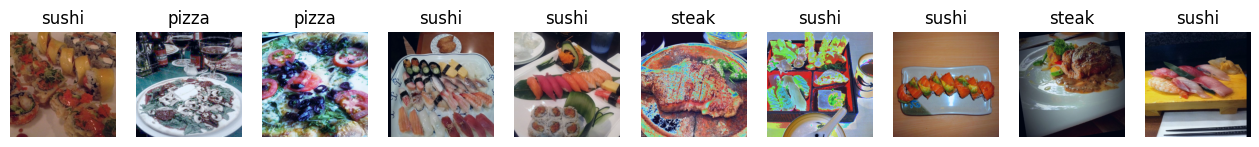

In [19]:
train_dataloader_20_percent_aug = create_dataloaders(train_dir=train_dir_20_percent, test_dir=None, train_transform=train_transform_data_aug, test_transform=None)[0]
view_dataloader_images(train_dataloader_20_percent_aug)

In [20]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb5"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {# "data_20_percent_no_aug": train_dataloader_20_percent, # This experiment was already run
                     "data_20_percent_aug": train_dataloader_20_percent_aug}

In [21]:
%%time
from going_modular.going_modular.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs:

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")

            # 7. Select the model
            if model_name == "effnetb0":
                model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb5() # creates a new model each time (important because we want each experiment to start from scratch)

            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))

            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")


[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent_aug
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2023-10-05/data_20_percent_aug/effnetb0/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9979 | train_acc: 0.5271 | test_loss: 0.7039 | test_acc: 0.8542
Epoch: 2 | train_loss: 0.7689 | train_acc: 0.8063 | test_loss: 0.6524 | test_acc: 0.8854
Epoch: 3 | train_loss: 0.6585 | train_acc: 0.8063 | test_loss: 0.4682 | test_acc: 0.9271
Epoch: 4 | train_loss: 0.5927 | train_acc: 0.8104 | test_loss: 0.4528 | test_acc: 0.9375
Epoch: 5 | train_loss: 0.5740 | train_acc: 0.7833 | test_loss: 0.3974 | test_acc: 0.9375
[INFO] Saving model to: models/07_effnetb0_data_20_percent_aug_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb5
[INFO] DataLoader: data_20_percent_aug
[INFO] Number of epochs: 5
[INFO] Created new effnetb5 model.
[INFO] Created SummaryWriter, saving to: runs/2023-10-05/data_20_percent_aug/effnetb5/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9371 | train_acc: 0.6354 | test_loss: 0.6663 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.6865 | train_acc: 0.8271 | test_loss: 0.5501 | test_acc: 0.8371
Epoch: 3 | train_loss: 0.6085 | train_acc: 0.8250 | test_loss: 0.4445 | test_acc: 0.8674
Epoch: 4 | train_loss: 0.5019 | train_acc: 0.8833 | test_loss: 0.3950 | test_acc: 0.8371
Epoch: 5 | train_loss: 0.4940 | train_acc: 0.8542 | test_loss: 0.3307 | test_acc: 0.9384
[INFO] Saving model to: models/07_effnetb5_data_20_percent_aug_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent_aug
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2023-10-05/data_20_percent_aug/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9979 | train_acc: 0.5271 | test_loss: 0.7039 | test_acc: 0.8542
Epoch: 2 | train_loss: 0.7689 | train_acc: 0.8063 | test_loss: 0.6524 | test_acc: 0.8854
Epoch: 3 | train_loss: 0.6585 | train_acc: 0.8063 | test_loss: 0.4682 | test_acc: 0.9271
Epoch: 4 | train_loss: 0.5927 | train_acc: 0.8104 | test_loss: 0.4528 | test_acc: 0.9375
Epoch: 5 | train_loss: 0.5740 | train_acc: 0.7833 | test_loss: 0.3974 | test_acc: 0.9375
Epoch: 6 | train_loss: 0.4724 | train_acc: 0.8917 | test_loss: 0.3759 | test_acc: 0.9583
Epoch: 7 | train_loss: 0.4456 | train_acc: 0.9021 | test_loss: 0.3225 | test_acc: 0.9375
Epoch: 8 | train_loss: 0.4561 | train_acc: 0.8542 | test_loss: 0.3232 | test_acc: 0.9479
Epoch: 9 | train_loss: 0.3832 | train_acc: 0.8833 | test_loss: 0.2969 | test_acc: 0.9479
Epoch: 10 | train_loss: 0.4611 | train_acc: 0.8708 | test_loss: 0.2862 | test_acc: 0.9583
[INFO] Saving model to: models/07_effnetb0_data_20_percent_aug_10_epochs.pth
--------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9371 | train_acc: 0.6354 | test_loss: 0.6663 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.6865 | train_acc: 0.8271 | test_loss: 0.5501 | test_acc: 0.8371
Epoch: 3 | train_loss: 0.6085 | train_acc: 0.8250 | test_loss: 0.4445 | test_acc: 0.8674
Epoch: 4 | train_loss: 0.5019 | train_acc: 0.8833 | test_loss: 0.3950 | test_acc: 0.8371
Epoch: 5 | train_loss: 0.4940 | train_acc: 0.8542 | test_loss: 0.3307 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.4209 | train_acc: 0.9000 | test_loss: 0.2915 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4356 | train_acc: 0.8771 | test_loss: 0.2530 | test_acc: 0.9583
Epoch: 8 | train_loss: 0.4053 | train_acc: 0.8688 | test_loss: 0.2363 | test_acc: 0.9583
Epoch: 9 | train_loss: 0.3763 | train_acc: 0.8979 | test_loss: 0.2320 | test_acc: 0.9583
Epoch: 10 | train_loss: 0.3869 | train_acc: 0.8479 | test_loss: 0.2344 | test_acc: 0.9583
[INFO] Saving model to: models/07_effnetb5_data_20_percent_aug_10_epochs.pth
--------------------------------

In [22]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
# %load_ext tensorboard
# %tensorboard --logdir runs

Data augmentation seems to more significantly improve the training of the smaller model. Whereas it does seem to hinder the bigger model's training.

## Exercise 3. Scale up the dataset to turn FoodVision Mini into FoodVision Big using the entire [Food101 dataset from `torchvision.models`](https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html#torchvision.datasets.Food101)
    
* You could take the best performing model from your various experiments or even the EffNetB2 feature extractor we created in this notebook and see how it goes fitting for 5 epochs on all of Food101.
* If you try more than one model, it would be good to have the model's results tracked.
* If you load the Food101 dataset from `torchvision.models`, you'll have to create PyTorch DataLoaders to use it in training.
* **Note:** Due to the larger amount of data in Food101 compared to our pizza, steak, sushi dataset, this model will take longer to train.

In [23]:
from torchvision import datasets

food101_train_data = datasets.Food101(root="data",
                                      split="train",
                                      transform=simple_transform,
                                      download=True)

food101_test_data = datasets.Food101(root="data",
                                     split="test",
                                     transform=simple_transform,
                                     download=True)

100%|██████████| 4996278331/4996278331 [03:05<00:00, 26957770.68it/s]


Extracting data/food-101.tar.gz to data


In [24]:
# Get class names
class_names_food101 = food101_train_data.classes

# Turn images into data loaders
train_dataloader_food101 = DataLoader(
    food101_train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

test_dataloader_food101 = DataLoader(
    food101_test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

In [25]:
# 1. Create epochs list
num_epochs = [5]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb5"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_food101": train_dataloader_food101}

In [ ]:
%%time
from going_modular.going_modular.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs:

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")

            # 7. Select the model
            if model_name == "effnetb0":
                model = create_effnetb0(len(class_names_food101)) # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb5(len(class_names_food101)) # creates a new model each time (important because we want each experiment to start from scratch)

            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader_food101,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))

            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb5
[INFO] DataLoader: data_food101
[INFO] Number of epochs: 5
[INFO] Created new effnetb5 model.
[INFO] Created SummaryWriter, saving to: runs/2023-10-05/data_food101/effnetb5/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3616 | train_acc: 0.4835 | test_loss: 1.5106 | test_acc: 0.6400
Epoch: 2 | train_loss: 1.7307 | train_acc: 0.5759 | test_loss: 1.3350 | test_acc: 0.6670
